In [7]:
import numpy as np
import pandas as pd
import utm
import math
import os
import sys
sys.path.append('./src')
sys.path.append('./map_matching')
import math
import time
import datetime
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt

import display_gm
import display_osm
import plot
import tools
import celltower as ctcrawler
from data_cleaning import noise
from HMMM.preprocessing import my_matcher as mmr

<h2>Data Process</h2>

In [2]:
def load_2g_gongcan(gongcan_2g):
    gongcan = pd.read_csv(gongcan_2g)
    # merged cell tower, origin cell tower
    m_towers, o_towers = dict(), dict()
    duplicate = defaultdict(list)
    dup_ids = []
    dup_set = set()
    for i in range(len(gongcan)):
        rncid, cellid, lng, lat, azimuth, downtilt = \
        gongcan.iloc[i]['RNCID'], gongcan.iloc[i]['CellID'], \
        gongcan.iloc[i]['Longitude'], gongcan.iloc[i]['Latitude'], \
        gongcan.iloc[i]['Azimuth'], gongcan.iloc[i]['Downtilt']
        if (lat, lng) not in duplicate.keys():
            m_towers[(rncid, cellid)] = (i, lat, lng, azimuth, downtilt)
        o_towers[(rncid, cellid)] = (i, lat, lng, azimuth, downtilt)
        duplicate[(lat, lng)].append(i)
    print 'How many Cell Tower: ', len(m_towers)
    iterator = (ids for loc, ids in duplicate.iteritems() if len(ids) > 1)
    for ids in iterator:
        dup_ids.append(ids)
        dup_set.update(ids)
    print 'duplicated cell towers:', dup_ids
    return m_towers, o_towers, dup_ids, dup_set

def parse_argv(feature):
    merge_tower = feature['merge_tower']
    neighbor = feature['neighbor']
    with_rssi = feature['with_rssi']
    radio_angle = feature['radio_angle']
    return merge_tower, neighbor, with_rssi, radio_angle

def find_cell_id(old_id, dup_set, dup_ids):
    if old_id not in dup_set:
        return old_id
    for ids in dup_ids:
        if old_id in ids:
            return ids[0]
    
def load_2g(file_2g, gongcan_2g, **feature):
    print type(feature)
    merge_tower, neighbor, with_rssi, radio_angle = parse_argv(feature)
    m_towers, o_towers, dup_ids, dup_set = load_2g_gongcan(gongcan_2g)
    towers = m_towers if merge_tower else o_towers
#     obsv = []
    db = defaultdict(list)
    df = pd.read_csv(file_2g)
    for i in range(len(df)):
        rid_1, cid_1, rssi_1, rid_2, cid_2, rssi_2, lat, lng, tr_id, timestp = \
        int(df.iloc[i]['RNCID_1']), int(df.iloc[i]['CellID_1']), int(df.iloc[i]['RSSI_1']), \
        int(df.iloc[i]['RNCID_2']), int(df.iloc[i]['CellID_2']), int(df.iloc[i]['RSSI_2']), \
        df.iloc[i]['Latitude'], df.iloc[i]['Longitude'], \
        int(df.iloc[i]['traj_id']), int(df.iloc[i]['MRTime']) / 1000
        index_1 = o_towers[(rid_1, cid_1)][0] if (rid_1, cid_1) in o_towers.keys() else -1
        index_2 = o_towers[(rid_2, cid_2)][0] if (rid_2, cid_2) in o_towers.keys() else -1
        if merge_tower:
            index_1 = find_cell_id(index_1, dup_set, dup_ids)
            index_2 = find_cell_id(index_2, dup_set, dup_ids)
        # 拼装输入数据特征
        point = (lat, lng, index_1, timestp)
        if neighbor:
            point = (lat, lng, index_1, index_2, timestp)
        if with_rssi:
            point = (lat, lng, index_1, rssi_1, timestp) if not neighbor else (lat, lng, index_1, rssi_1, index_2, rssi_2, timestp)
        db[tr_id].append(point)
        
    return db, towers
#         obsv.append((lat, lng, index_1, index_2))


In [17]:
file_2g = './jiading/data_2g.csv'
gongcan_2g = './jiading/2g_gongcan.csv'
db, towers = load_2g(file_2g, gongcan_2g, merge_tower=True, neighbor=True, with_rssi=False, radio_angle=False)
print 'len(db):', len(db)

<type 'dict'>
How many Cell Tower:  62
duplicated cell towers: [[0, 13], [14, 22, 25], [4, 11], [5, 16], [19, 20], [3, 10, 24], [1, 7, 23]]
len(db): 25


<h2>Missed Traj ID</h2>

In [ ]:
traj_ids = []
tid = -1
stime = 0
for i in range(len(df)):
    rid_1, cid_1, rid_2, cid_2, lat, lng, ctime = int(df.iloc[i]['RNCID_1']), int(df.iloc[i]['CellID_1']), \
    int(df.iloc[i]['RNCID_2']), int(df.iloc[i]['CellID_2']), \
    df.iloc[i]['Latitude'], df.iloc[i]['Longitude'], int(df.iloc[i]['MRTime']) / 1000
    if ctime-stime >= 10:
        tid += 1
    traj_ids.append(tid)
    stime = ctime
df.insert(loc=2, column='traj_id', value=traj_ids)
df.to_csv('./jiading/data_2g.csv', index=False)

<h2>Data Cleaning</h2>

In [18]:
noise = reload(noise)
# cleaned db
dbs = dict()
min_traj_len = 10
idx = 0
for i in range(len(db)):
    ranges = noise.makeTrajs(db[i], max_dist=200.0)
    print 'origin id=', i
    out = ''
    for a, b in tools.pairwise(ranges):
        if b - a < min_traj_len:
            continue
            out += 'discard[%d:%d]\t' % (a, b)
        dbs[idx] = db[i][a:b]
        out += 'keep[%d:%d]as id=%d\t' % (a, b, idx)
        idx += 1
    print out
    
print len(dbs)

origin id= 0
keep[0:15]as id=0	
origin id= 1

origin id= 2
keep[1:719]as id=1	
origin id= 3
keep[0:581]as id=2	
origin id= 4
keep[2:208]as id=3	
origin id= 5
keep[0:386]as id=4	
origin id= 6
keep[0:327]as id=5	
origin id= 7
keep[0:323]as id=6	keep[323:656]as id=7	
origin id= 8

origin id= 9

origin id= 10

origin id= 11

origin id= 12
keep[0:111]as id=8	
origin id= 13

origin id= 14

origin id= 15
keep[0:309]as id=9	
origin id= 16
keep[0:307]as id=10	keep[307:367]as id=11	
origin id= 17
keep[0:340]as id=12	
origin id= 18
keep[0:421]as id=13	keep[421:793]as id=14	
origin id= 19
keep[2:342]as id=15	
origin id= 20
keep[0:151]as id=16	keep[151:447]as id=17	
origin id= 21
keep[0:265]as id=18	
origin id= 22

origin id= 23
keep[0:39]as id=19	
origin id= 24
keep[3:171]as id=20	
21


In [ ]:
display_osm = reload(display_osm)
for i in range(len(dbs)):
    display_osm.path_to_html(dbs[i], edges, './display/path/%d.html' % i)

In [8]:
mmr = reload(mmr)
road_network = './Shanghai/SH_map'
sequences = dbs
alg_name = 'HMM'
search_radius = 50
time_gap = 5
max_route_distance = 2000000

start = time.time()
paths = mmr.map_match(road_network, sequences, search_radius,time_gap, max_route_distance)
end = time.time()
print 'Total cost:', (end - start), 's'

Total cost: 6.56100010872 s


num of obsv:  174
1 93
2 36
3 15
4 11
5 4
6 6
7 2
9 2
10 2
11 1
12 2


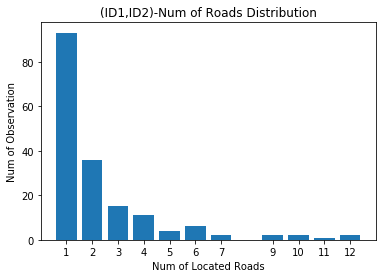

In [19]:
def find_matches_with(tr_id, idx, paths):
    for s, e, rid in paths[tr_id]:
        if s <= idx <= e:
            return rid
    return -1

O = dict()
summary = defaultdict(int)
obsv_set = set()
for tr_id, points in dbs.iteritems():
    for idx, point in enumerate(points):
        lat, lng, id1, id2 = point[:4]
        obsv = (id1, id2)
        obsv_set.add(obsv)
        rid = find_matches_with(tr_id, idx, paths)
        if obsv not in O.keys():
            O[obsv] = dict()
        if rid not in O[obsv].keys():
            O[obsv][rid] = 0
        O[obsv][rid] += 1

print 'num of obsv: ', len(obsv_set)
for obsv in O.iterkeys():
    num = len(O[obsv])
    summary[num] += 1

for num, val in summary.iteritems():
    print num, val
plt.bar(summary.keys(), height=summary.values())
xticks = [str(x) for x in summary.keys()]
plt.xticks(summary.keys(), xticks)
plt.title('(ID1,ID2)-Num of Roads Distribution')
plt.xlabel('Num of Located Roads')
plt.ylabel('Num of Observation')
plt.show()

In [ ]:
summary = []
for state in D.iterkeys():
    rid = sag.get_cid(state)
    to_time = sum(times for obsv, times in D[state].iteritems())
    to_obsv = len(D[state])
    summary.append((rid, to_obsv, to_time))
#     print 'Cell[%d] has %d obsv, with %d times...' % (cid, to_obsv, to_time)
df_freq = pd.DataFrame(summary, columns=['CellID', 'Obsv', 'Points'])
df_freq.describe()

<h2>Map Matching</h2>

In [ ]:
for i in range(len(dbs)):
    to_write = ''
    with open('./jiading/trajs/traj_%d.txt' % i, 'w') as fout:
        for lat, lng, _, _, ctime in dbs[i]:
            to_write += '%s,%s,%s\n' % (ctime, lat, lng)
        fout.write(to_write)

In [7]:
in_folder = './Shanghai/edgegeometry'
in_file = 'SH_EdgeGeometry.txt'
edges = dict()
with open(in_folder + '/' + in_file) as f:
    cnt = 0
    for line in f:
        nodes = []
        data = [float(d) for d in line.strip().split('^')[4:]]
        rid = int(line.strip().split('^')[0])
        lngs, lats = data[1::2], data[::2]
        edges[rid] = [(lat, lng) for lat, lng in zip(lats, lngs)]
        cnt += 1
print len(edges)

235


In [8]:
for i in range(len(dbs)):
    rids = []
    # (a, b, rid)
    path = []
    with open('./jiading/trajs/traj_%d.txt.HMM.G5.csv' % i) as fout:
        cnt = 0
        for line in fout:
            data = line.strip().split(',')
            if len(data)==1:
                continue
            rid = int(data[3])
            rids.append(rid)
            cnt += 1
    last_rid = 0
    last_idx = 0
    for idx in range(len(rids)):
        rid = rids[idx]
        if rid != last_rid and last_rid != 0:
            path.append((last_idx, idx - 1, last_rid))
            last_idx = idx
        last_rid = rid
    path.append((last_idx, len(rids) - 1, rid))
    ids = []
    for a, b, rid in path:
    #     print '[%d, %d]-rid %d' % (a, b, rid)
        ids.append(rid)
    print 'rid = %d:' % i
    print ids

rid = 0:
[164316039]
rid = 1:
[164316066, 164316057, 266157883, 164316030, 164316024, 164316065, 164316047, 263922901, 263922900, 263922899, 164316030, 164316039, 164316009, 266161866, 164316070, 164316010, 164316077, 164316016, 164316012, 164316031, 164316021, 164316057]
rid = 2:
[164316066, 164316021, 164316012, 164316056, 266345024, 164316011, 164316046, 164316014, 266157883, 135420817, 135420819, 384531666]
rid = 3:
[164316014, 266207478, 164316014, 384531665, 164316009, 266161866]
rid = 4:
[164316012, 164316031, 164316021, 164316057, 266157883, 164316030]
rid = 5:
[135419988, 135372842, 266221576]
rid = 6:
[263913994, 266207478, 266207479]
rid = 7:
[135419988, 135372842, 266221576, 164316030, 263913992]
rid = 8:
[164316014, 263913992]
rid = 9:
[263913994, 164316030, 266221576, 135372842, 384531666]
rid = 10:
[164316066, 135419988, 135382788, 135427149, 164316014]
rid = 11:
[164316057, 266157883]
rid = 12:
[266157883, 164316014, 384531665, 164316009, 266161866, 164316070, 164316010

<h2>Missed Cell Tower</h2>

In [ ]:
scells = set()

for i in range(len(df)):
    rid_1, cid_1, rid_2, cid_2, lat, lng, trid = int(df.iloc[i]['RNCID_1']), int(df.iloc[i]['CellID_1']), \
    int(df.iloc[i]['RNCID_2']), int(df.iloc[i]['CellID_2']), \
    df.iloc[i]['Latitude'], df.iloc[i]['Longitude'], int(df.iloc[i]['traj_id'])
    scells.add((rid_1, cid_1))
    scells.add((rid_2, cid_2))
# dc = pd.DataFrame(list(scells), columns=["RNCID", "CellID"])
# print dc
# dc.to_csv('./jiading/gongcan_lost.csv', index=False)
print 'origin: ', len(cells)
print 'now need: ', len(scells)

In [ ]:
gongcan_new = []
fcells = dict()
missed = []
for i in range(len(f_gongcan)):
    try:
        lat, lng, rncid, cellid, azimuth, downtilt = f_gongcan.iloc[i]['纬度'], f_gongcan.iloc[i]['经度'], \
        (f_gongcan.iloc[i]['LAC']), (f_gongcan.iloc[i]['CI']), \
        (f_gongcan.iloc[i]['方位角']), (f_gongcan.iloc[i]['天线下倾角'])
    except:
        print i
    fcells[(rncid, cellid)] = (lat, lng, azimuth, downtilt)
print 'final gongcan has: ', len(fcells)
total = 0
for rncid, cellid in scells:
    try:
        lat, lng, azimuth, downtilt = fcells[(rncid, cellid)]
        gongcan_new.append((rncid, cellid, lat, lng, azimuth, downtilt))
    except:
        total += 1
        missed.append((rncid, cellid))
#         print rncid, cellid
print 'missed: ', total
print 'contains now: ', len(gongcan_new)


In [ ]:
_, o_towers, _, _ = load.load_2g_gongcan(gongcan_2g)
df = pd.read_csv(file_2g)
missed = set()
for i in range(len(df)):
        piece_data = df.iloc[i]
        rid_1, cid_1, rssi_1, rid_2, cid_2, rssi_2, lat, lng, speed, tr_id, timestp = \
        int(piece_data['RNCID_1']), int(piece_data['CellID_1']), int(piece_data['Dbm_1']), \
        int(piece_data['RNCID_2']), int(piece_data['CellID_2']), int(piece_data['Dbm_2']), \
        float(piece_data['Latitude']), float(piece_data['Longitude']), float(piece_data['Speed']), \
        int(piece_data['TrajID']), int(piece_data['MRTime']) / 1000
        if (rid_1, cid_1) not in o_towers.keys():
            missed.add((rid_1, cid_1))
        if (rid_1, cid_1) not in o_towers.keys():
            missed.add((rid_2, cid_2))
print len(missed)

In [ ]:
ctcrawler = reload(ctcrawler)
crawler = ctcrawler.CellTower()
updated = crawler.get_tower(missed)

In [ ]:
# print updated
gongcan_new.extend(updated)
dc = pd.DataFrame(gongcan_new, columns=["RNCID", "CellID", "Latitude", "Longitude", "Azimuth", "Downtilt"])
dc.to_csv('./jiading/2g_gongcan.csv', index=False)

<h2>1.Particle Filtering</h2>

In [ ]:
hmm = reload(hmm)
predict_p = dict()
cnt = 0
for tr_id, traj in test.iteritems():
    obsv = traj[0][2:]
    N = len(D) * 4
    particles, init_rids = hmm.Particle.create_by_prior_dist(obsv, D, B_, N)
    try:
        result = hmm.particle_filter(traj, A, B_, particles, 100)
    except:
        print 'traj id:', tr_id, ' failed...'
        continue
    predict_p[tr_id] = result
    cnt += 1
    print 'traj id:', tr_id, ' success'
print 'success:', cnt